In [25]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pickle
import torch
import lightning

from itertools import combinations
from mlcolvar.cvs import BaseCV
from mlcolvar.core.transform import Transform
from mlcolvar.core import FeedForward, Normalization

np.bool = np.bool_

CUDA_DEVICE = 0
blue = (70 / 255, 110 / 255, 250 / 255)

# INPUT_DIM = 45
# MLCV_DIM = 1
# TICA_SWITCH = True
# dim_normalization = False
# date = "0811_162324"
# date = "0812_125447" # 5k
# date = "0816_171833" # 50k
# molecule = "CLN025"

MLCV_DIM = 1
INPUT_DIM = 190
TICA_SWITCH = False
molecule = "2JOF"
date = "0812_125552"
dim_normalization = False

save_path  = f"/home/shpark/prj-mlcv/lib/bioemu/model/{date}/mlcv_model.pt"

# Load

In [26]:
# Model class definition

class DIM_NORMALIZATION(Transform):
    def __init__(
        self,
        feature_dim = 1
    ):
        super().__init__(in_features=feature_dim, out_features=feature_dim)
        self.register_buffer("feature_dim", torch.tensor(feature_dim))
        
    def forward(self, x):
        x = torch.nn.functional.normalize(x, dim=-1)
        return x

class MLCV(BaseCV, lightning.LightningModule):
    BLOCKS = ["norm_in", "encoder",]

    def __init__(
        self,
        mlcv_dim: int,
        encoder_layers: list,
        dim_normalization: bool = False,
        options: dict = None,
        **kwargs,
    ):
        super().__init__(in_features=encoder_layers[0], out_features=encoder_layers[-1], **kwargs)
        # ======= OPTIONS =======
        options = self.parse_options(options)
        
        # ======= BLOCKS =======
        # initialize norm_in
        o = "norm_in"
        if (options[o] is not False) and (options[o] is not None):
            self.norm_in = Normalization(self.in_features, **options[o])

        # initialize encoder
        o = "encoder"
        self.encoder = FeedForward(encoder_layers, **options[o])
        if dim_normalization:
        	self.postprocessing = DIM_NORMALIZATION(mlcv_dim)


In [27]:
# Load model

model_state = torch.load(save_path)
print(model_state.keys())

mlcv_state_dict = model_state["mlcv_state_dict"]
encoder_layers = [INPUT_DIM, 100, 100, MLCV_DIM]
options = {
	"encoder": {
		"activation": "tanh",
		"dropout": [0.1, 0.1, 0.1]
	},
	"norm_in": {
	},
}
mlcv_model = MLCV(
    mlcv_dim = MLCV_DIM,
	encoder_layers = encoder_layers,
	dim_normalization = dim_normalization,
	options = options
)

mlcv_model.load_state_dict(mlcv_state_dict)
mlcv_model.eval()
print(mlcv_model)

dict_keys(['mlcv_state_dict'])
MLCV(
  (norm_in): Normalization(in_features=190, out_features=190, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=190, out_features=100, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Dropout(p=0.1, inplace=False)
    )
  )
)


In [28]:
# TICA Model
lag = 10

class TICA_WRAPPER:
    """TICA wrapper for coordinate transformation."""
    def __init__(self, tica_model_path, pdb_path, tica_switch: bool = False):
        with open(tica_model_path, 'rb') as f:
            self.tica_model = pickle.load(f)
        self.pdb = md.load(pdb_path)
        self.ca_resid_pair = np.array(
            [(a.index, b.index) for a, b in combinations(list(self.pdb.topology.residues), 2)]
        )
        self.tica_switch = tica_switch
        print(f"Loaded TICA model: {self.tica_model}")

    def transform(self, cad_data: np.ndarray):
        if self.tica_switch:
            cad_data = (1 - np.power(cad_data / 0.8, 6)) / (1 - np.power(cad_data / 0.8, 12))
        tica_coord = self.tica_model.transform(cad_data)
        return tica_coord

    def pos2cad(self, pos_data: np.ndarray):
        self.pdb.xyz = pos_data
        ca_pair_distances, _ = md.compute_contacts(
            self.pdb, scheme="ca", contacts=self.ca_resid_pair, periodic=False
        )
        return ca_pair_distances

if TICA_SWITCH:
	tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl"
else:
	tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_lag{lag}.pkl"         
tica_wrapper = TICA_WRAPPER(
	tica_model_path=tica_model_path,
	pdb_path=f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb",
	tica_switch=TICA_SWITCH
)

Loaded TICA model: TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


In [29]:
# Committor model
committor_path = "./committor.pt"
committor_model = torch.jit.load(committor_path, map_location=f"cuda:{CUDA_DEVICE}")
print(committor_model)

RecursiveScriptModule(
  original_name=NN_committor_guess
  (nn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=CustomActivation)
  )
)


In [30]:
# Load data
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"
pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-pos.pt"
cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-cad.pt"
pos_torch = torch.load(pos_path)
cad_torch = torch.load(cad_path)
print(f"Position shape: {pos_torch.shape}")
print(f"CAD shape: {cad_torch.shape}")

if molecule == "CLN025":
	bond_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-bond_num_distance.pt"
	label_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-label_distance.pt"
	bond_torch = torch.load(bond_path)
	label_torch = torch.load(label_path)
	print(bond_torch.shape)
	print(label_torch.shape)

Position shape: torch.Size([1044000, 272, 3])
CAD shape: torch.Size([1044000, 190])


# Analysis

## CV

In [31]:
cad_data = cad_torch.numpy()
cv = mlcv_model(torch.from_numpy(cad_data))
cv = cv.detach().cpu().numpy()

print(cv.shape)
print(cv.max(), cv.min())
MLCV_DIM = cv.shape[1]

(1044000, 1)
10.398798 -10.108323


In [32]:
# Normalization CV
cv_normalized = np.zeros_like(cv)

for cv_dim in range(MLCV_DIM):
	cv_dim_val = cv[:, cv_dim]
	cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
	cv_range_mean = (cv_range_min + cv_range_max) / 2.0
	cv_range = (cv_range_max - cv_range_min) / 2.0
	cv_normalized[:, cv_dim] = (cv_dim_val - cv_range_mean) / cv_range

	print(f"< CV {cv_dim} >")
	print(f"  range_min: {cv_range_min:.4f}")
	print(f"  range_max: {cv_range_max:.4f}")
	print(f"  range_mean: {cv_range_mean:.4f}")

cv = cv_normalized

for cv_dim in range(MLCV_DIM):
	cv_dim_val = cv[:, cv_dim]
	cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
	cv_range_mean = (cv_range_min + cv_range_max) / 2.0
	cv_range = (cv_range_max - cv_range_min) / 2.0
	print(f"< Normalized CV {cv_dim} >")
	print(f"  range_min: {cv_range_min:.4f}")
	print(f"  range_max: {cv_range_max:.4f}")
	print(f"  range_mean: {cv_range_mean:.4f}")

< CV 0 >
  range_min: -10.1083
  range_max: 10.3988
  range_mean: 0.1452
< Normalized CV 0 >
  range_min: -1.0000
  range_max: 1.0000
  range_mean: 0.0000


In [33]:
cv = -cv

## TICA and CVs

In [14]:
# 2D TICA coordinates
tica_data = tica_wrapper.transform(cad_data)
x = tica_data[:, 0]
y = tica_data[:, 1]

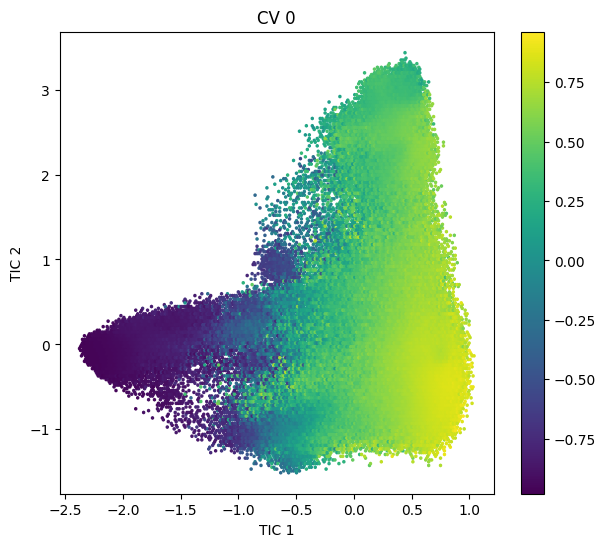

In [15]:
# 2D TICA plot
for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	hb = ax.hexbin(
		x, y, C=cv[:, cv_dim],
		gridsize=200,                     # controls resolution
		reduce_C_function=np.mean,       # compute average per hexagon
		cmap='viridis',                  # colormap
	)
	plt.colorbar(hb)
	plt.xlabel("TIC 1")
	plt.ylabel("TIC 2")
	plt.title(f"CV {cv_dim}")
	plt.savefig(f"/home/shpark/prj-mlcv/lib/bioemu/model/{date}/tica-cv{cv_dim}.png")
	plt.show()

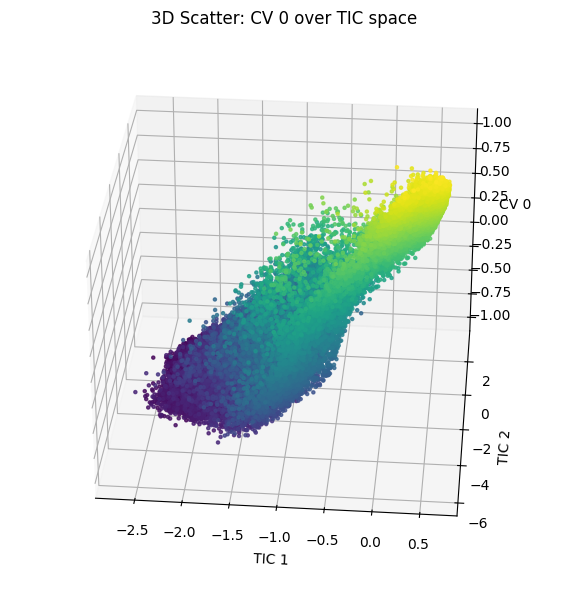

In [59]:
# 3D scatter plot
for cv_dim in range(MLCV_DIM):
	z = cv[:, cv_dim]

	fig = plt.figure(figsize=(8, 6))
	ax = fig.add_subplot(111, projection='3d')

	sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=5, alpha=0.8)

	ax.set_xlabel('TIC 1')
	ax.set_ylabel('TIC 2')
	ax.set_zlabel(f'CV {cv_dim}')
	ax.set_title(f'3D Scatter: CV {cv_dim} over TIC space')
	ax.view_init(azim=-85)
	# fig.colorbar(sc, ax=ax, label='CV Value')

	plt.tight_layout()
	plt.show()

In [60]:
# Interactive 3D TICA plot

# # Loop over each CV dimension
# for cv_dim in range(MLCV_DIM):
#     z = cv[:, cv_dim]

#     fig = go.Figure(
#         data=go.Scatter3d(
#             x=x,
#             y=y,
#             z=z,
#             mode='markers',
#             marker=dict(
#                 size=3,
#                 color=z,
#                 colorscale='Viridis',
#                 colorbar=dict(title=f'CV {cv_dim}'),
#                 opacity=0.8
#             )
#         )
#     )

#     fig.update_layout(
#         scene=dict(
#             xaxis_title='TIC 1',
#             yaxis_title='TIC 2',
#             zaxis_title=f'CV {cv_dim}',
# 			aspectmode='manual',
#         	aspectratio=dict(x=1, y=1, z=1)
#         ),
#         title=f'CV {cv_dim} in TICA Space',
#         margin=dict(l=0, r=0, b=0, t=30)
#     )

#     fig.show()

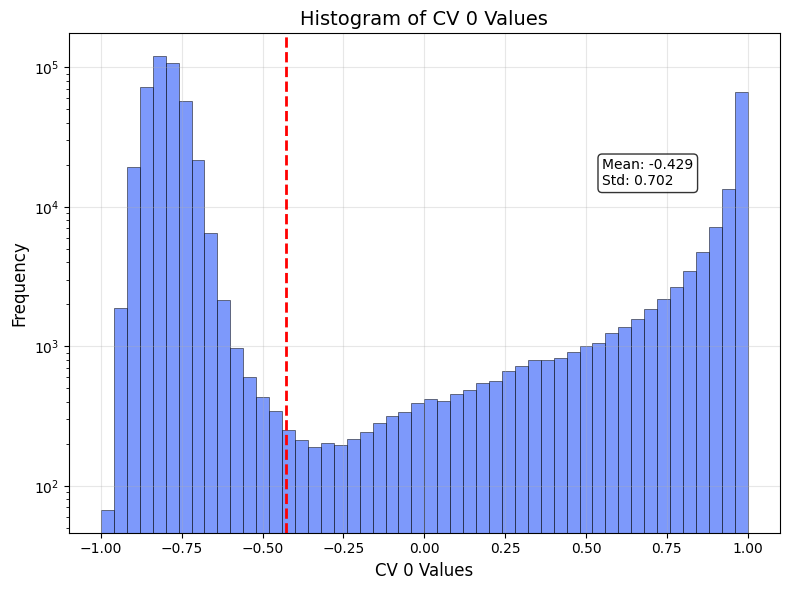

CV 0 Statistics:
  Total samples: 530000
  Mean: -0.428770
  Standard deviation: 0.701657


In [61]:
# CV Histogram

n_bins = 50

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
counts, bins, patches = ax.hist(
    cv_dim_val,
    bins=n_bins,
    alpha=0.7,
    color=blue,
    edgecolor='black',
    linewidth=0.5,
    log=True,
)

# Add statistics text
mean_val = np.mean(cv_dim_val)
std_val = np.std(cv_dim_val)
min_val = np.min(cv_dim_val)
max_val = np.max(cv_dim_val)

stats_text = f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}'
ax.text(0.75, 0.75, stats_text, transform=ax.transAxes, 
		bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
		verticalalignment='top', fontsize=10)
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')

ax.set_xlabel(f'CV {cv_dim} Values', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'Histogram of CV {cv_dim} Values', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"CV {cv_dim} Statistics:")
print(f"  Total samples: {len(cv_dim_val)}")
print(f"  Mean: {mean_val:.6f}")
print(f"  Standard deviation: {std_val:.6f}")

## Bond number and CVs

In [ ]:
bond_num_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-bond_num-distance_angle.pt"
bond_num_torch = torch.load(bond_num_path)
bond_num = bond_num_torch.numpy()

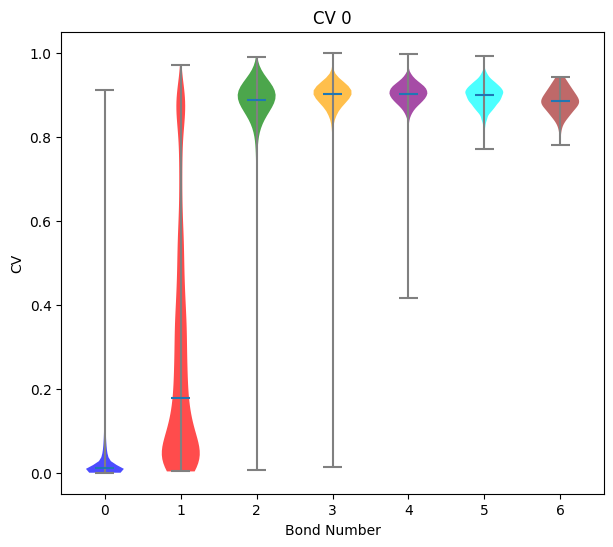

In [63]:
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown', 'magenta']

for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	cv_dim_val = cv[:, cv_dim]
	range_min, range_max = cv_dim_val.min(), cv_dim_val.max()
	x = (cv_dim_val - range_min) / (range_max - range_min)
	y = bond_num
	grouped = [x[y == i] for i in sorted(np.unique(y))]
	violin = plt.violinplot(grouped, positions=sorted(np.unique(y)), showmeans=False, showmedians=True)
	for i, body in enumerate(violin['bodies']):
		body.set_facecolor(colors[i % len(colors)])
		body.set_alpha(0.7)

	violin['cbars'].set_edgecolor('gray')
	violin['cmaxes'].set_edgecolor('gray')
	violin['cmins'].set_edgecolor('gray')

	ax.set_xlabel("Bond Number")
	ax.set_ylabel("CV")
	ax.set_title(f"CV {cv_dim}")
	plt.show()


## Committor and CVs

In [64]:
from scipy.stats import pearsonr

committor_value = committor_model(cad_torch.to(CUDA_DEVICE))
committor_value = committor_value.cpu().detach().numpy().flatten()

In [65]:
# Pearson correlation between committor values and CV values
from scipy.stats import pearsonr
import pandas as pd

print("Pearson Correlation Analysis")
print("=" * 50)

# Compute correlations for each CV dimension
correlation_results = []

for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    
    # Compute Pearson correlation
    correlation, p_value = pearsonr(committor_value, cv_values)
    
    correlation_results.append({
        'CV_Dimension': cv_dim,
        'Correlation': correlation,
        'P_Value': p_value,
        'Correlation_Strength': 'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'
    })
    
    print(f"CV {cv_dim} vs Committor:")
    print(f"  Pearson correlation: {correlation:.6f}")
    print(f"  P-value: {p_value:.2e}")
    print(f"  Correlation strength: {correlation_results[-1]['Correlation_Strength']}")
    print()

# Create a summary DataFrame
df_correlations = pd.DataFrame(correlation_results)
print("Summary Table:")
print(df_correlations.to_string(index=False))

# Additional correlations with other variables
print("\n" + "=" * 50)
print("Additional Correlations")
print("=" * 50)

# Correlation with TICA coordinates
tica_x = tica_data[:, 0]
tica_y = tica_data[:, 1]

corr_tica_x, p_tica_x = pearsonr(committor_value, tica_x)
corr_tica_y, p_tica_y = pearsonr(committor_value, tica_y)

print(f"Committor vs TICA-1: r = {corr_tica_x:.6f}, p = {p_tica_x:.2e}")
print(f"Committor vs TICA-2: r = {corr_tica_y:.6f}, p = {p_tica_y:.2e}")

# Correlation with bond number
corr_bond, p_bond = pearsonr(committor_value, bond_num)
print(f"Committor vs Bond Number: r = {corr_bond:.6f}, p = {p_bond:.2e}")

# Cross-correlations between variables
print(f"\nCross-correlations:")
for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    corr_cv_tica1, p_cv_tica1 = pearsonr(cv_values, tica_x)
    corr_cv_tica2, p_cv_tica2 = pearsonr(cv_values, tica_y)
    corr_cv_bond, p_cv_bond = pearsonr(cv_values, bond_num)
    
    print(f"CV {cv_dim} vs TICA-1: r = {corr_cv_tica1:.6f}")
    print(f"CV {cv_dim} vs TICA-2: r = {corr_cv_tica2:.6f}")
    print(f"CV {cv_dim} vs Bond Number: r = {corr_cv_bond:.6f}")
    print()


Pearson Correlation Analysis
CV 0 vs Committor:
  Pearson correlation: -0.984131
  P-value: 0.00e+00
  Correlation strength: Strong

Summary Table:
 CV_Dimension  Correlation  P_Value Correlation_Strength
            0    -0.984131      0.0               Strong

Additional Correlations
Committor vs TICA-1: r = -0.983871, p = 0.00e+00
Committor vs TICA-2: r = -0.086205, p = 0.00e+00
Committor vs Bond Number: r = -0.920363, p = 0.00e+00

Cross-correlations:
CV 0 vs TICA-1: r = 0.994076
CV 0 vs TICA-2: r = 0.006761
CV 0 vs Bond Number: r = 0.920358



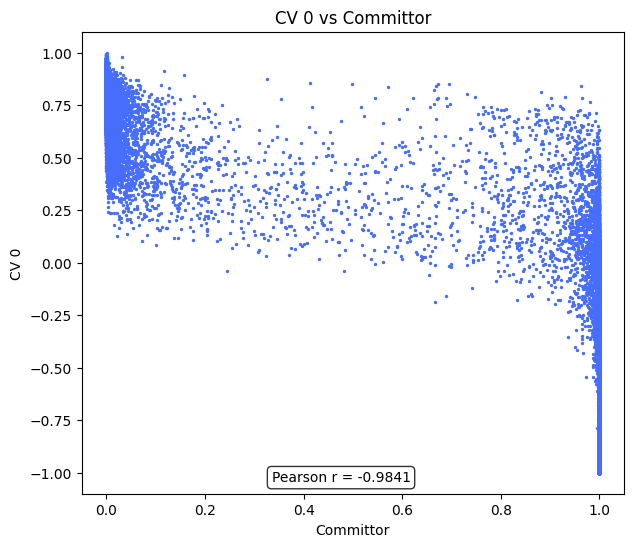

In [66]:
for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	ax.scatter(committor_value, cv[:, cv_dim], color=blue, s=2)
	correlation, p_value = pearsonr(committor_value, cv[:, cv_dim])
	correlation_text = f'Pearson r = {correlation:.4f}'
	ax.text(
		0.35, 0.05,
		correlation_text,
		transform=ax.transAxes, 
		bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
		verticalalignment='top', fontsize=10
	)
	ax.set_xlabel("Committor")
	ax.set_ylabel(f"CV {cv_dim}")
	ax.set_title(f"CV {cv_dim} vs Committor")
	plt.show()

## Folded state RMSD and CVs

(530000,)
(530000, 1)


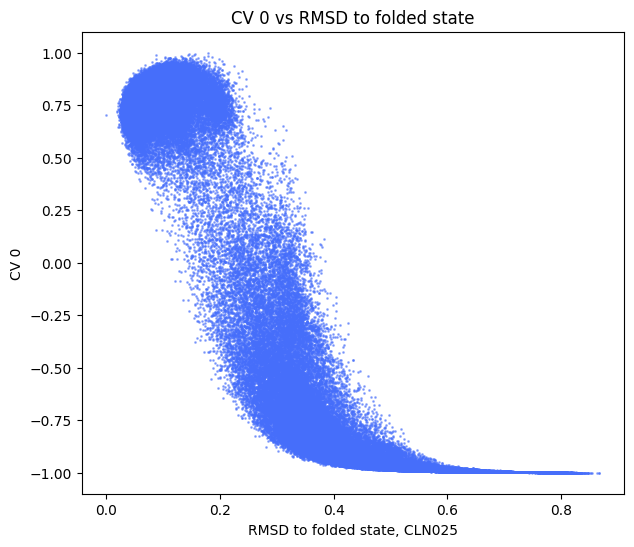

In [67]:
rmsd_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-label_rmsd.pt"
rmsd = torch.load(rmsd_path).numpy()[:530000]
print(rmsd.shape)
print(cv.shape)

for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	ax.scatter(
		rmsd,
		cv[:, cv_dim],
		color=blue,
		s=1,
		alpha=0.5,
	)
	ax.set_xlabel(f"RMSD to folded state, {molecule}")
	ax.set_ylabel(f"CV {cv_dim}")
	ax.set_title(f"CV {cv_dim} vs RMSD to folded state")
	plt.show()

## Secondary structure

### Full

In [8]:
dssp_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp.npy"
dssp = np.load(dssp_path)
print(np.unique(dssp))
print(dssp.shape)
print(dssp[0])

[' ' 'B' 'E' 'G' 'H' 'I' 'S' 'T']
(1044000, 20)
[' ' ' ' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T' 'H' 'H' 'H' 'H' 'T' ' ' ' ' ' '
 ' ' ' ']


Secondary structure types: [' ' 'B' 'E' 'G' 'H' 'I' 'S' 'T']
\nCreating violin plot for Coil...


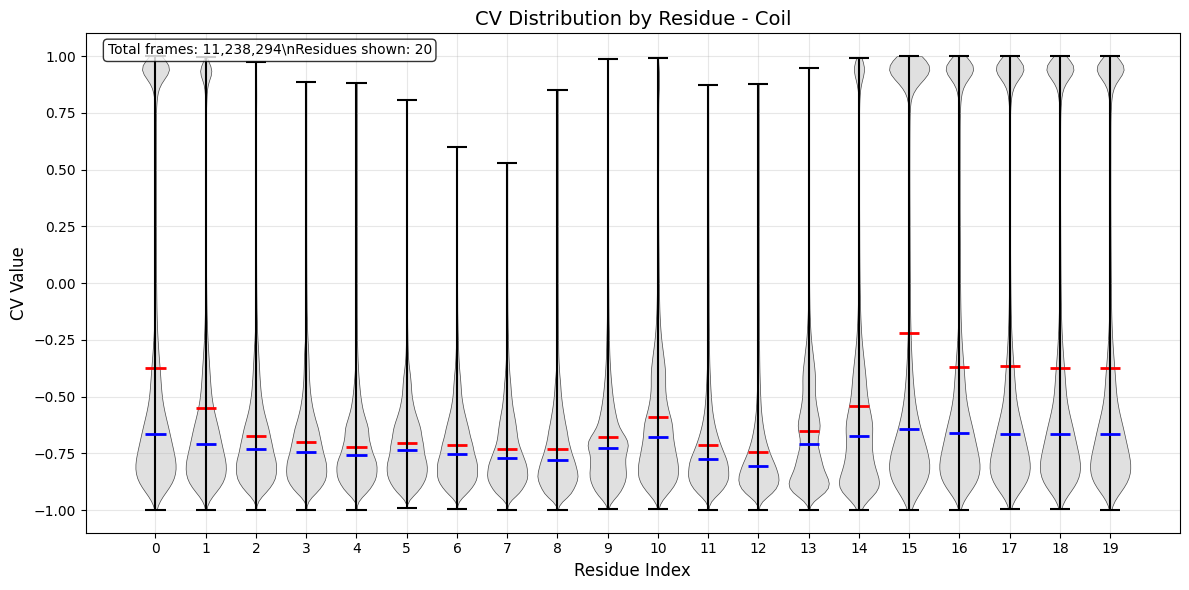

  - Residues with Coil: 20
  - Total data points: 11,238,294
  - Average points per residue: 561914.7
\nCreating violin plot for Secondary Structure B...


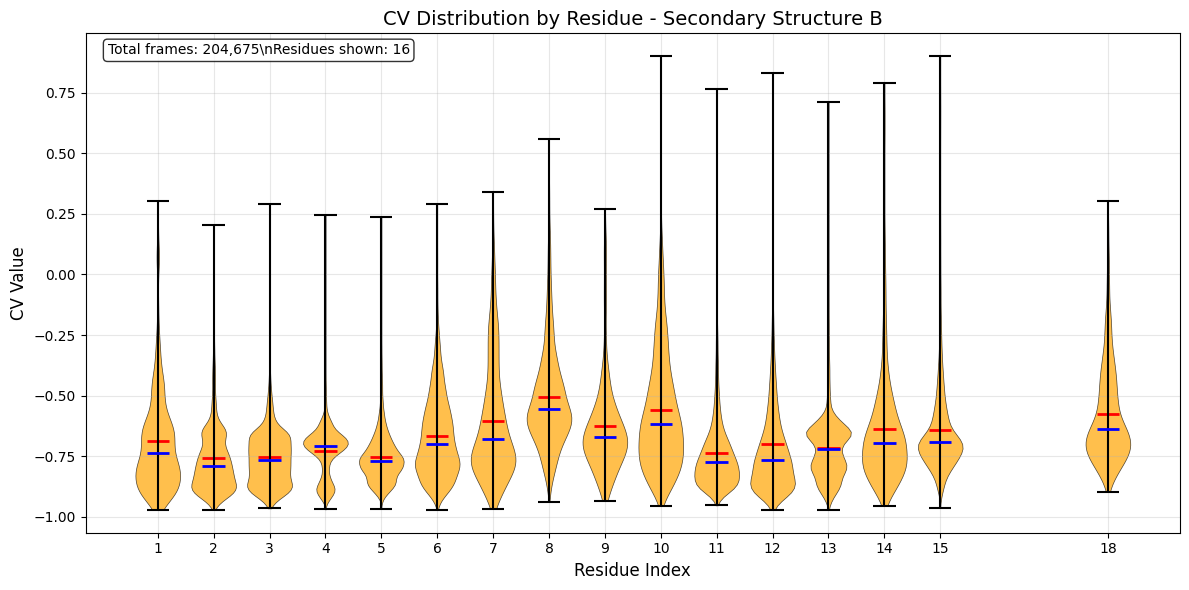

  - Residues with Secondary Structure B: 16
  - Total data points: 204,675
  - Average points per residue: 12792.2
\nCreating violin plot for Secondary Structure E...


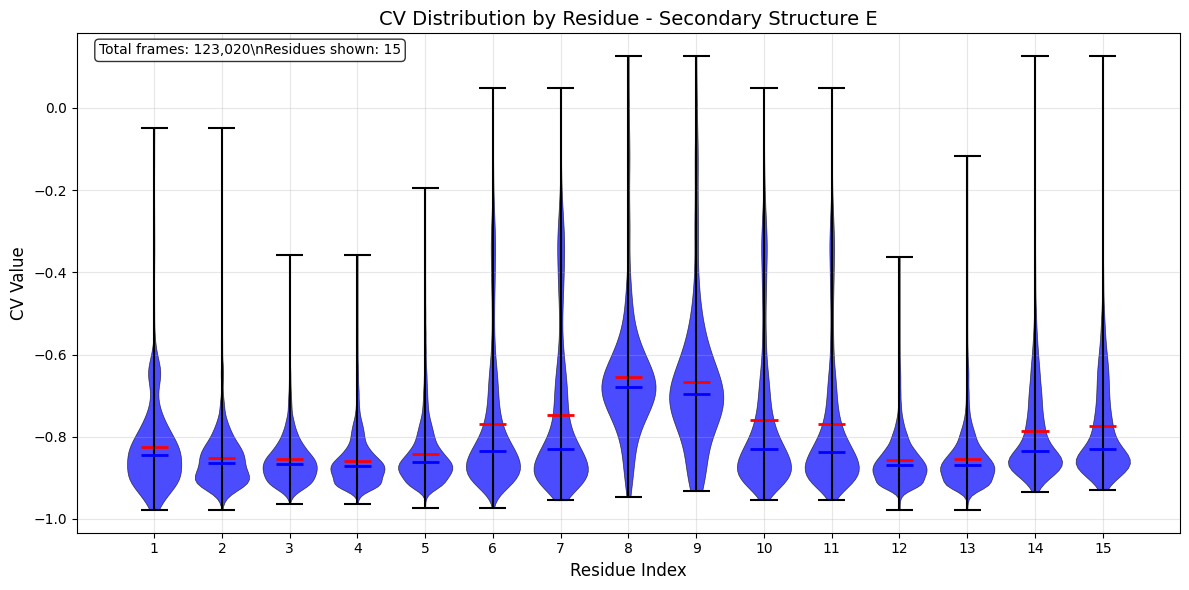

  - Residues with Secondary Structure E: 15
  - Total data points: 123,020
  - Average points per residue: 8201.3
\nCreating violin plot for Secondary Structure G...


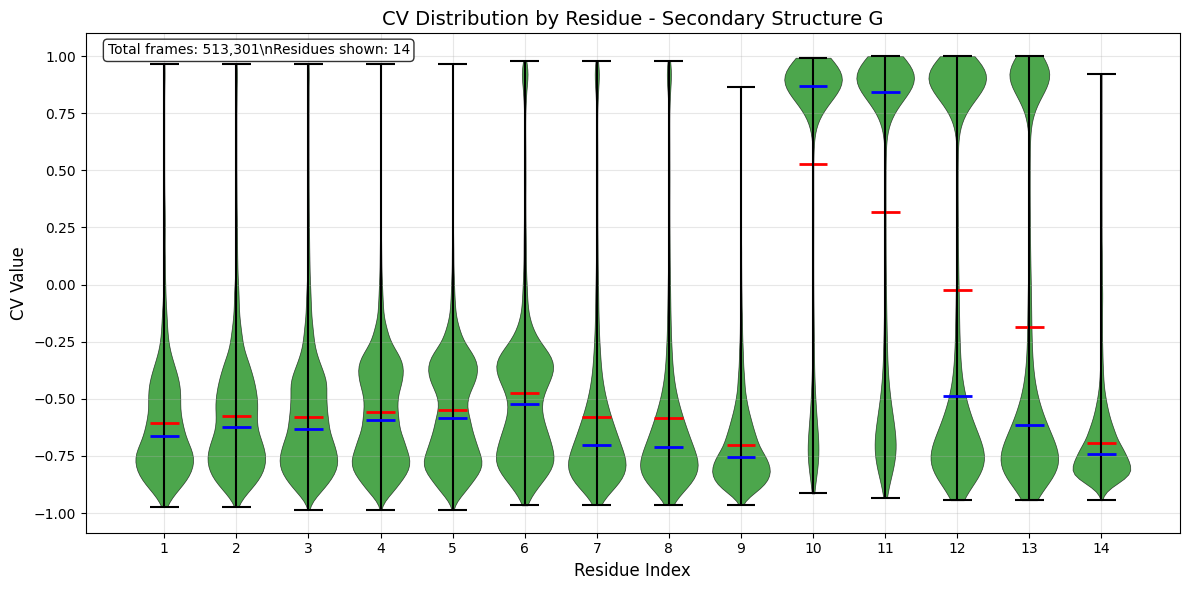

  - Residues with Secondary Structure G: 14
  - Total data points: 513,301
  - Average points per residue: 36664.4
\nCreating violin plot for Secondary Structure H...


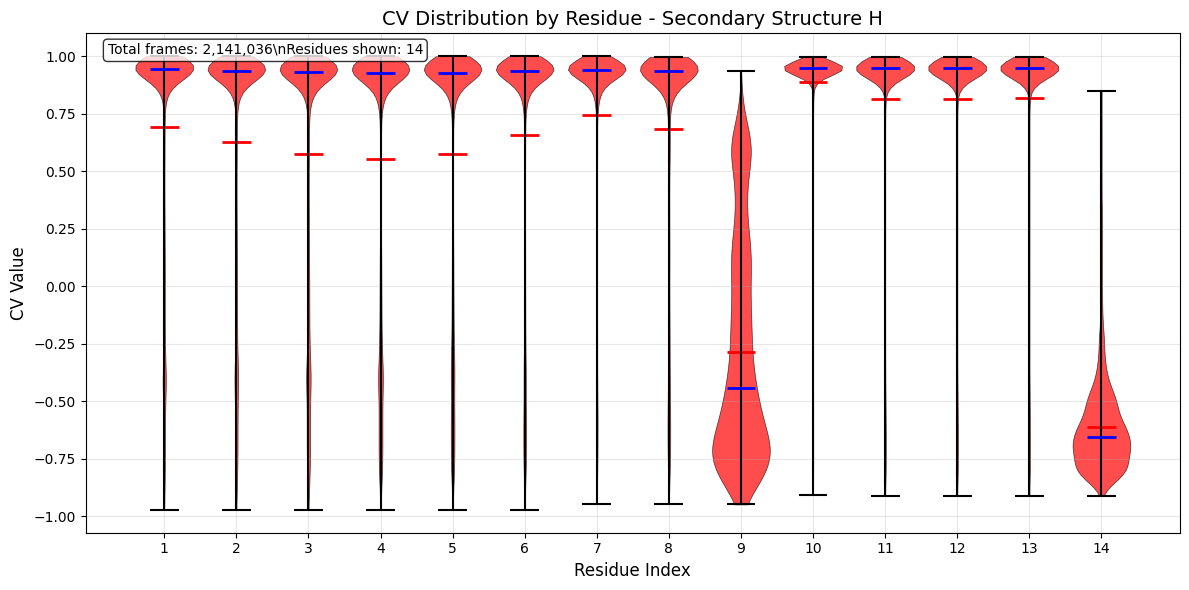

  - Residues with Secondary Structure H: 14
  - Total data points: 2,141,036
  - Average points per residue: 152931.1
\nCreating violin plot for Secondary Structure I...


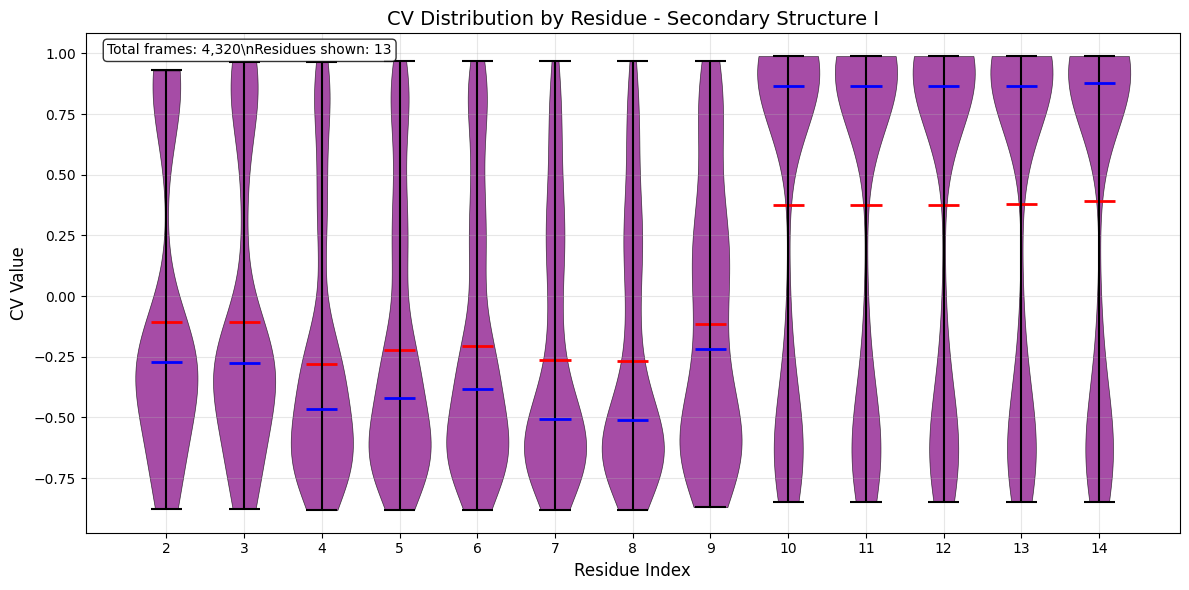

  - Residues with Secondary Structure I: 13
  - Total data points: 4,320
  - Average points per residue: 332.3
\nCreating violin plot for Secondary Structure S...


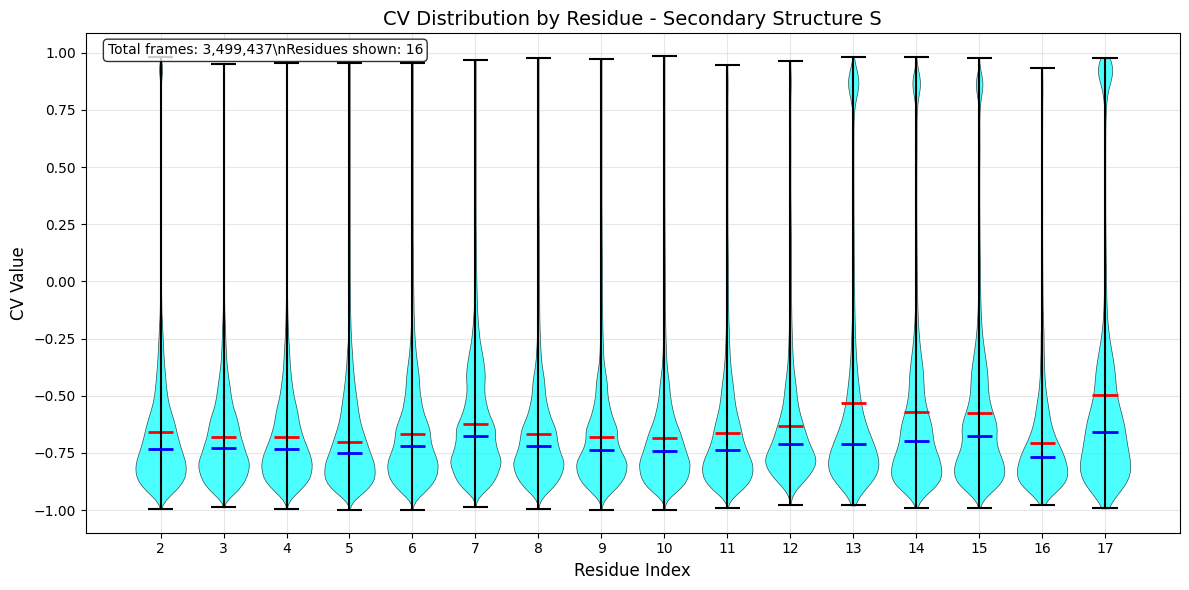

  - Residues with Secondary Structure S: 16
  - Total data points: 3,499,437
  - Average points per residue: 218714.8
\nCreating violin plot for Secondary Structure T...


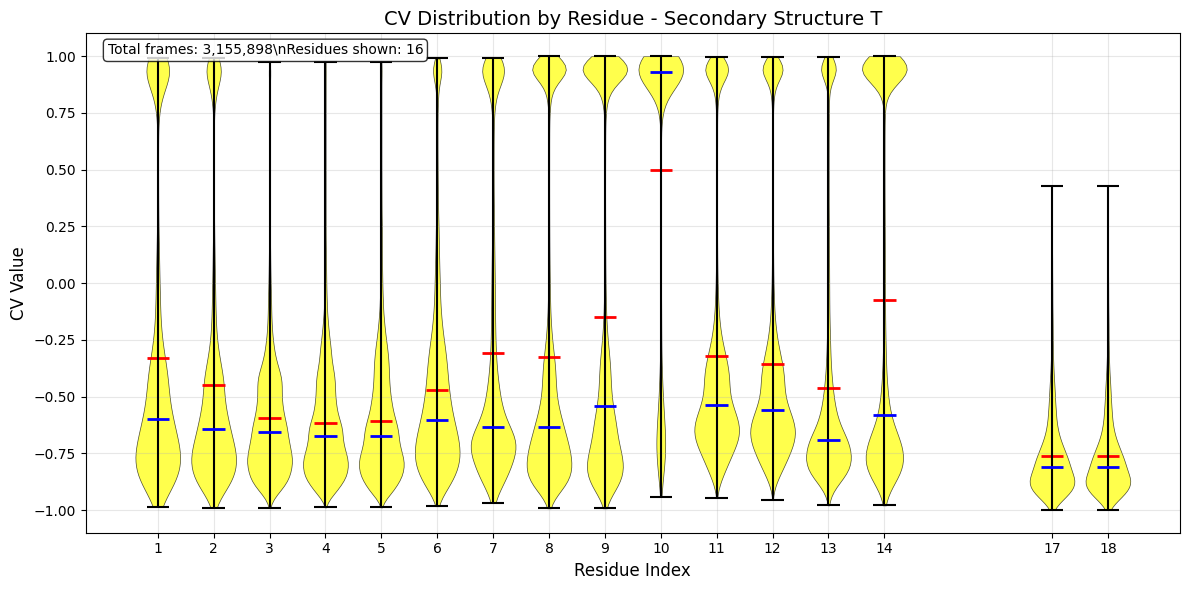

  - Residues with Secondary Structure T: 16
  - Total data points: 3,155,898
  - Average points per residue: 197243.6
\nViolin plots completed!


In [ ]:
## Secondary Structure Violin Plots by Residue

import seaborn as sns
from collections import defaultdict

# Secondary structure types in the data
ss_types = np.unique(dssp)
print(f"Secondary structure types: {ss_types}")

# Colors for different secondary structures
ss_colors = {
    ' ': 'lightgray',    # Coil
    'B': 'orange',       # Beta bridge
    'E': 'blue',         # Extended/Beta sheet
    'G': 'green',        # 3-helix
    'H': 'red',          # Alpha helix
    'I': 'purple',       # 5-helix/Pi helix
    'S': 'cyan',         # Bend
    'T': 'yellow'        # Turn
}

# Create a separate plot for each secondary structure type
for ss_type in ss_types:
    if ss_type == ' ':
        ss_name = 'Coil'
    else:
        ss_name = f'Secondary Structure {ss_type}'
    
    print(f"\nCreating violin plot for {ss_name}...")
    
    # Collect CV values for each residue that has this secondary structure
    residue_cv_data = defaultdict(list)
    
    # For each CV dimension
    for cv_dim in range(MLCV_DIM):
        cv_values = cv[:, cv_dim]
        
        # Go through each frame
        for frame_idx in range(len(dssp)):
            # Check each residue in this frame
            for residue_idx in range(dssp.shape[1]):
                if dssp[frame_idx, residue_idx] == ss_type:
                    residue_cv_data[residue_idx].append(cv_values[frame_idx])
    
    # Only plot if we have data for this secondary structure
    if residue_cv_data:
        # Prepare data for violin plot
        residues = sorted(residue_cv_data.keys())
        cv_data_by_residue = [residue_cv_data[res] for res in residues]
        
        # Filter out residues with too few data points
        min_points = 100  # Minimum number of points for a meaningful violin
        filtered_residues = []
        filtered_cv_data = []
        
        for i, res in enumerate(residues):
            if len(cv_data_by_residue[i]) >= min_points:
                filtered_residues.append(res)
                filtered_cv_data.append(cv_data_by_residue[i])
        
        if filtered_cv_data:
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Create violin plot
            violin_parts = ax.violinplot(
                filtered_cv_data,
                positions=filtered_residues,
                showmeans=True,
                showmedians=True,
                widths=0.8
            )
            
            # Style the violins
            for pc in violin_parts['bodies']:
                pc.set_facecolor(ss_colors.get(ss_type, 'gray'))
                pc.set_alpha(0.7)
                pc.set_edgecolor('black')
                pc.set_linewidth(0.5)
            
            # Style other elements
            violin_parts['cbars'].set_edgecolor('black')
            violin_parts['cmaxes'].set_edgecolor('black')
            violin_parts['cmins'].set_edgecolor('black')
            violin_parts['cmeans'].set_edgecolor('red')
            violin_parts['cmeans'].set_linewidth(2)
            violin_parts['cmedians'].set_edgecolor('blue')
            violin_parts['cmedians'].set_linewidth(2)
            
            # Customize plot
            ax.set_xlabel('Residue Index', fontsize=12)
            ax.set_ylabel('CV Value', fontsize=12)
            ax.set_title(f'CV Distribution by Residue - {ss_name}', fontsize=14)
            ax.grid(True, alpha=0.3)
            
            # Add statistics text
            total_frames = sum(len(data) for data in filtered_cv_data)
            stats_text = f'Total frames: {total_frames:,}\nResidues shown: {len(filtered_residues)}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top', fontsize=10)
            
            # Set x-axis ticks
            if len(filtered_residues) <= 20:
                ax.set_xticks(filtered_residues)
            else:
                # Show every 5th residue if too many
                step = max(1, len(filtered_residues) // 10)
                tick_positions = filtered_residues[::step]
                ax.set_xticks(tick_positions)
            
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            print(f"  - Residues with {ss_name}: {len(filtered_residues)}")
            print(f"  - Total data points: {total_frames:,}")
            print(f"  - Average points per residue: {total_frames/len(filtered_residues):.1f}")
        else:
            print(f"  - Not enough data points for {ss_name} (minimum {min_points} required)")
    else:
        print(f"  - No data found for {ss_name}")

print("\nViolin plots completed!")


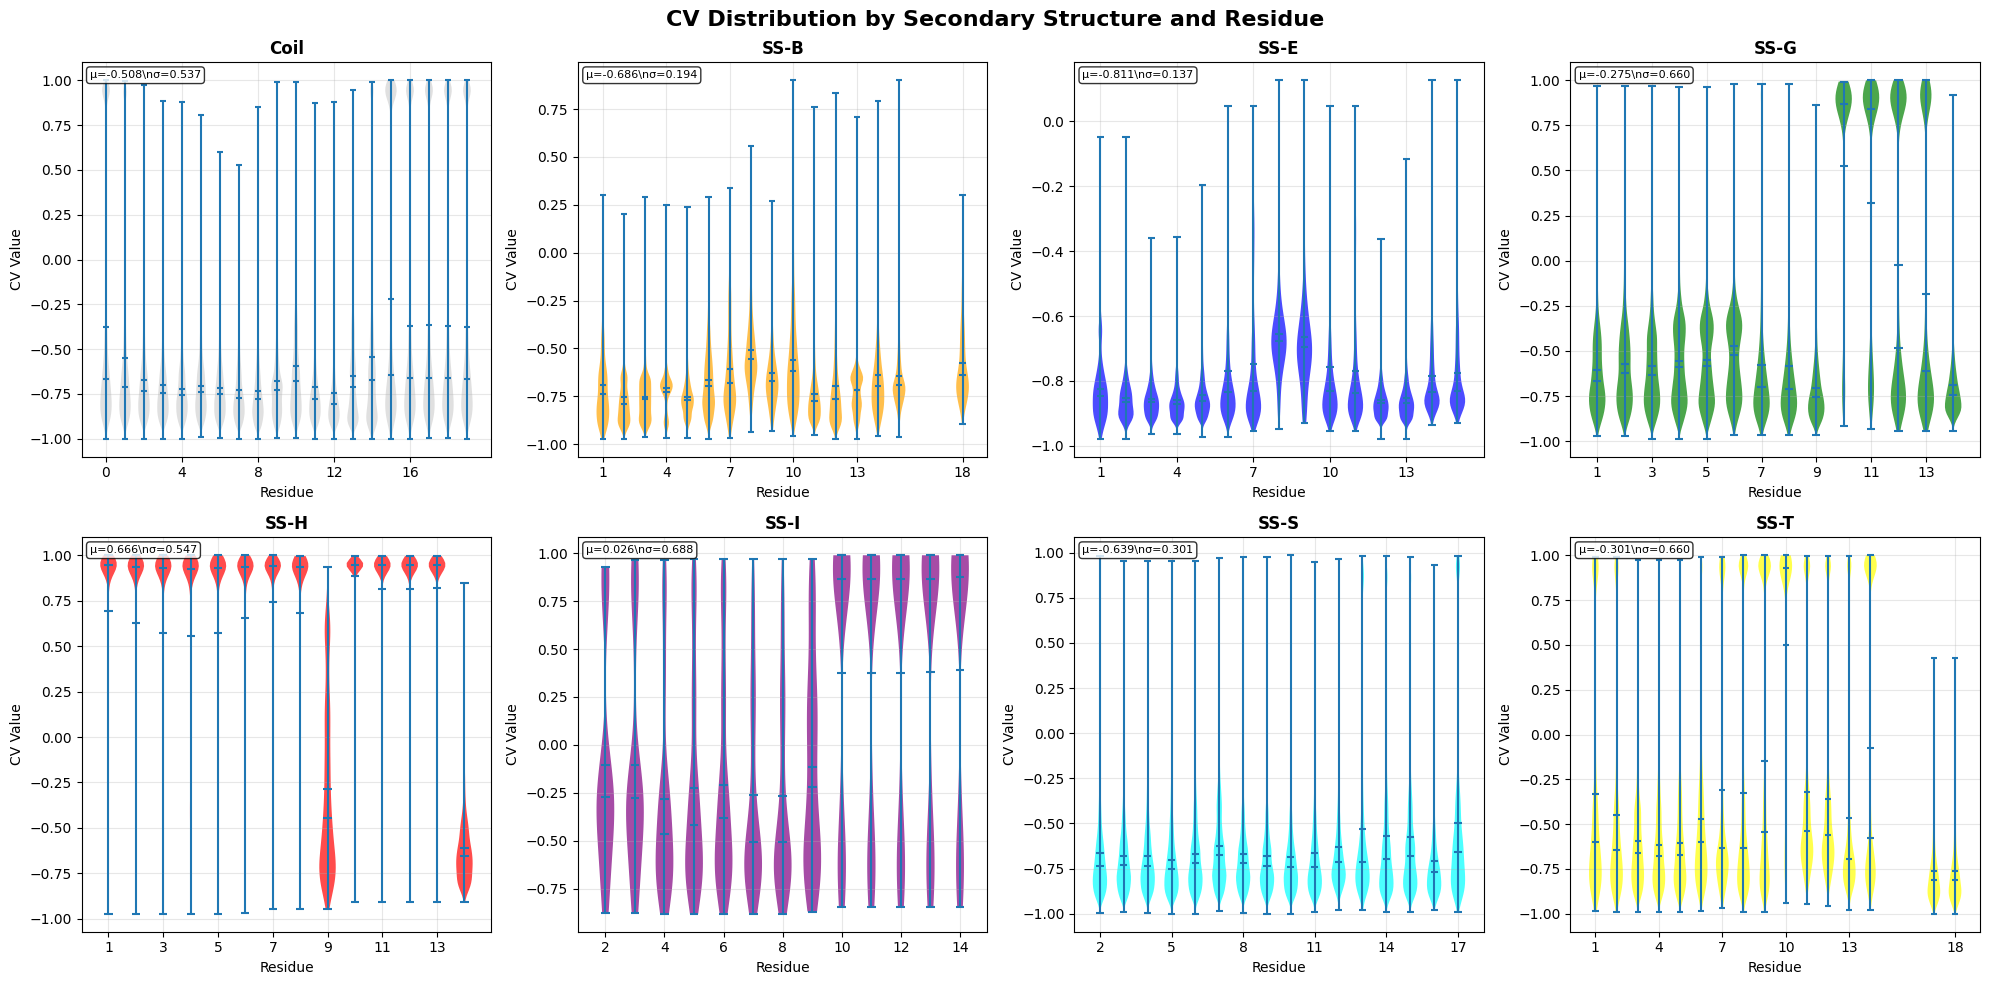

\nSecondary Structure Summary Statistics:
SS Type  Name         Mean CV    Std CV     Residues   Frames      
------------------------------------------------------------
         Coil         -0.5085    0.5369     20         11,238,294  
B        SS-B         -0.6858    0.1936     16         204,675     
E        SS-E         -0.8112    0.1369     15         123,020     
G        SS-G         -0.2745    0.6600     14         513,301     
H        SS-H         0.6658     0.5470     14         2,141,036   
I        SS-I         0.0262     0.6883     13         4,320       
S        SS-S         -0.6389    0.3009     16         3,499,437   
T        SS-T         -0.3008    0.6596     16         3,155,898   
\nTotal secondary structure types with data: 8


In [ ]:
## Enhanced Secondary Structure Analysis

# Create a comprehensive summary plot showing all secondary structures
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

ss_summary_stats = {}

for idx, ss_type in enumerate(ss_types):
    if idx >= len(axes):
        break
        
    ax = axes[idx]
    
    if ss_type == ' ':
        ss_name = 'Coil'
    else:
        ss_name = f'SS-{ss_type}'
    
    # Collect CV values for this secondary structure
    residue_cv_data = defaultdict(list)
    
    for cv_dim in range(MLCV_DIM):
        cv_values = cv[:, cv_dim]
        
        for frame_idx in range(len(dssp)):
            for residue_idx in range(dssp.shape[1]):
                if dssp[frame_idx, residue_idx] == ss_type:
                    residue_cv_data[residue_idx].append(cv_values[frame_idx])
    
    if residue_cv_data:
        residues = sorted(residue_cv_data.keys())
        cv_data_by_residue = [residue_cv_data[res] for res in residues if len(residue_cv_data[res]) >= 50]
        filtered_residues = [res for res in residues if len(residue_cv_data[res]) >= 50]
        
        if cv_data_by_residue:
            # Create violin plot
            violin_parts = ax.violinplot(
                cv_data_by_residue,
                positions=filtered_residues,
                showmeans=True,
                showmedians=True,
                widths=0.6
            )
            
            # Style
            for pc in violin_parts['bodies']:
                pc.set_facecolor(ss_colors.get(ss_type, 'gray'))
                pc.set_alpha(0.7)
            
            ax.set_title(f'{ss_name}', fontsize=12, fontweight='bold')
            ax.set_xlabel('Residue', fontsize=10)
            ax.set_ylabel('CV Value', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            # Calculate statistics
            all_cv_values = [val for data in cv_data_by_residue for val in data]
            ss_summary_stats[ss_type] = {
                'name': ss_name,
                'mean_cv': np.mean(all_cv_values),
                'std_cv': np.std(all_cv_values),
                'residue_count': len(filtered_residues),
                'total_frames': len(all_cv_values),
                'color': ss_colors.get(ss_type, 'gray')
            }
            
            # Add statistics text
            stats_text = f'μ={np.mean(all_cv_values):.3f}\nσ={np.std(all_cv_values):.3f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top', fontsize=8)
            
            # Adjust x-axis
            if len(filtered_residues) > 10:
                step = max(1, len(filtered_residues) // 5)
                tick_positions = filtered_residues[::step]
                ax.set_xticks(tick_positions)
        else:
            ax.text(0.5, 0.5, 'Insufficient Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{ss_name} (No Data)', fontsize=12)
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{ss_name} (No Data)', fontsize=12)

# Hide unused subplots
for idx in range(len(ss_types), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('CV Distribution by Secondary Structure and Residue', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSecondary Structure Summary Statistics:")
print("=" * 60)
print(f"{'SS Type':<8} {'Name':<12} {'Mean CV':<10} {'Std CV':<10} {'Residues':<10} {'Frames':<12}")
print("-" * 60)

for ss_type, stats in ss_summary_stats.items():
    print(f"{ss_type:<8} {stats['name']:<12} {stats['mean_cv']:<10.4f} {stats['std_cv']:<10.4f} "
          f"{stats['residue_count']:<10} {stats['total_frames']:<12,}")

print(f"\nTotal secondary structure types with data: {len(ss_summary_stats)}")


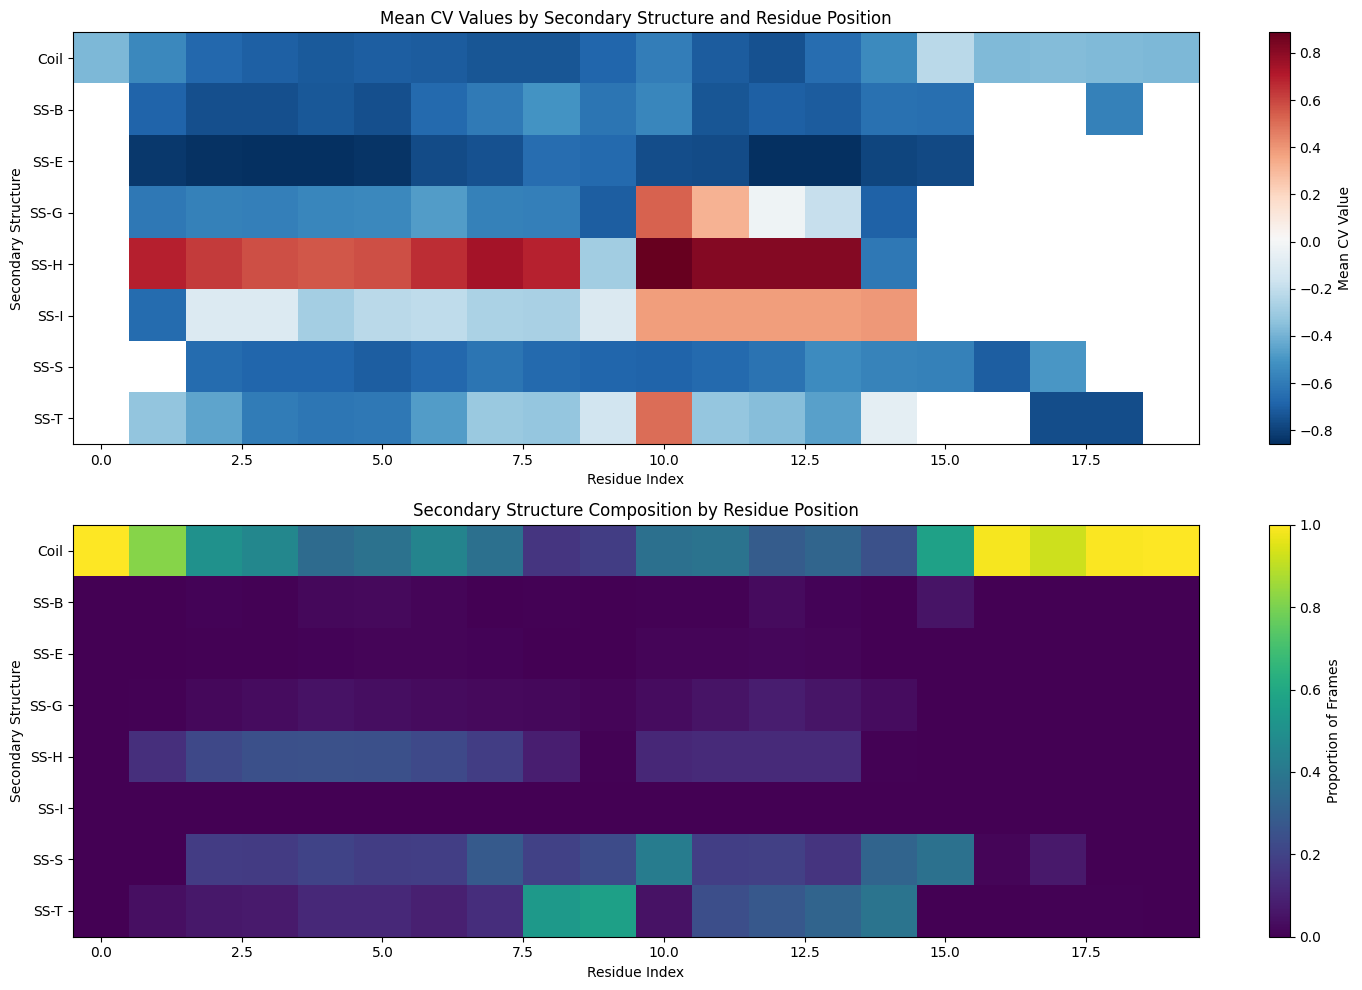

\nStatistical Analysis of CV by Secondary Structure:
One-way ANOVA:
  F-statistic: 1453838.2500
  P-value: 0.00e+00
  Significant difference: Yes

Pairwise CV Distribution Comparisons (t-tests):
--------------------------------------------------
Coil vs SS-B:
  t-statistic: 149.2467
  p-value: 0.00e+00
  Significant: Yes

Coil vs SS-E:
  t-statistic: 197.6586
  p-value: 0.00e+00
  Significant: Yes

Coil vs SS-G:
  t-statistic: -301.9437
  p-value: 0.00e+00
  Significant: Yes

Coil vs SS-H:
  t-statistic: -2924.1586
  p-value: 0.00e+00
  Significant: Yes

Coil vs SS-I:
  t-statistic: -65.2077
  p-value: 0.00e+00
  Significant: Yes

Coil vs SS-S:
  t-statistic: 433.7859
  p-value: 0.00e+00
  Significant: Yes

Coil vs SS-T:
  t-statistic: -575.7974
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-E:
  t-statistic: 199.1731
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-G:
  t-statistic: -277.2018
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-H:
  t-statistic: -1111.3590
  p-val

In [ ]:
## Comparative Analysis and Heatmap

# Create a heatmap showing mean CV values for each secondary structure at each residue
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Prepare data for heatmap
residue_range = range(dssp.shape[1])  # All residue positions
heatmap_data = np.full((len(ss_types), len(residue_range)), np.nan)
ss_type_labels = []

for ss_idx, ss_type in enumerate(ss_types):
    ss_name = 'Coil' if ss_type == ' ' else f'SS-{ss_type}'
    ss_type_labels.append(ss_name)
    
    for res_idx in residue_range:
        # Collect CV values for this residue when it has this secondary structure
        cv_values_for_residue = []
        
        for frame_idx in range(len(dssp)):
            if dssp[frame_idx, res_idx] == ss_type:
                cv_values_for_residue.append(cv[frame_idx, 0])  # Using first CV dimension
        
        if len(cv_values_for_residue) > 10:  # Minimum threshold for meaningful average
            heatmap_data[ss_idx, res_idx] = np.mean(cv_values_for_residue)

# Plot heatmap
im1 = ax1.imshow(heatmap_data, aspect='auto', cmap='RdBu_r', interpolation='nearest')
ax1.set_xlabel('Residue Index')
ax1.set_ylabel('Secondary Structure')
ax1.set_title('Mean CV Values by Secondary Structure and Residue Position')
ax1.set_yticks(range(len(ss_type_labels)))
ax1.set_yticklabels(ss_type_labels)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Mean CV Value')

# Create a secondary structure composition plot
ss_composition = np.zeros((len(ss_types), dssp.shape[1]))

for res_idx in range(dssp.shape[1]):
    for frame_idx in range(len(dssp)):
        ss_type = dssp[frame_idx, res_idx]
        ss_idx = list(ss_types).index(ss_type)
        ss_composition[ss_idx, res_idx] += 1

# Normalize to get proportions
ss_composition = ss_composition / len(dssp)

# Plot composition
im2 = ax2.imshow(ss_composition, aspect='auto', cmap='viridis', interpolation='nearest')
ax2.set_xlabel('Residue Index')
ax2.set_ylabel('Secondary Structure')
ax2.set_title('Secondary Structure Composition by Residue Position')
ax2.set_yticks(range(len(ss_type_labels)))
ax2.set_yticklabels(ss_type_labels)

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Proportion of Frames')

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nStatistical Analysis of CV by Secondary Structure:")
print("=" * 65)

from scipy import stats

# Collect CV values for each secondary structure type
ss_cv_distributions = {}
for ss_type in ss_types:
    cv_values = []
    for frame_idx in range(len(dssp)):
        for res_idx in range(dssp.shape[1]):
            if dssp[frame_idx, res_idx] == ss_type:
                cv_values.append(cv[frame_idx, 0])
    if cv_values:
        ss_cv_distributions[ss_type] = np.array(cv_values)

# Perform ANOVA test
if len(ss_cv_distributions) > 1:
    # Prepare data for ANOVA
    anova_data = [values for values in ss_cv_distributions.values() if len(values) > 100]
    
    if len(anova_data) > 1:
        f_stat, p_value = stats.f_oneway(*anova_data)
        print(f"One-way ANOVA:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  P-value: {p_value:.2e}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        print()

# Pairwise comparisons
print("Pairwise CV Distribution Comparisons (t-tests):")
print("-" * 50)

ss_types_with_data = [ss for ss in ss_types if ss in ss_cv_distributions and len(ss_cv_distributions[ss]) > 100]

for i, ss1 in enumerate(ss_types_with_data):
    for ss2 in ss_types_with_data[i+1:]:
        t_stat, p_val = stats.ttest_ind(ss_cv_distributions[ss1], ss_cv_distributions[ss2])
        ss1_name = 'Coil' if ss1 == ' ' else f'SS-{ss1}'
        ss2_name = 'Coil' if ss2 == ' ' else f'SS-{ss2}'
        
        print(f"{ss1_name} vs {ss2_name}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_val:.2e}")
        print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")
        print()

print("Analysis completed! 🎉")


### Simplified

Creating per-residue secondary structure violin plots...
Available secondary structure types: ['C' 'E' 'H']
Found 14 residues with sufficient secondary structure diversity


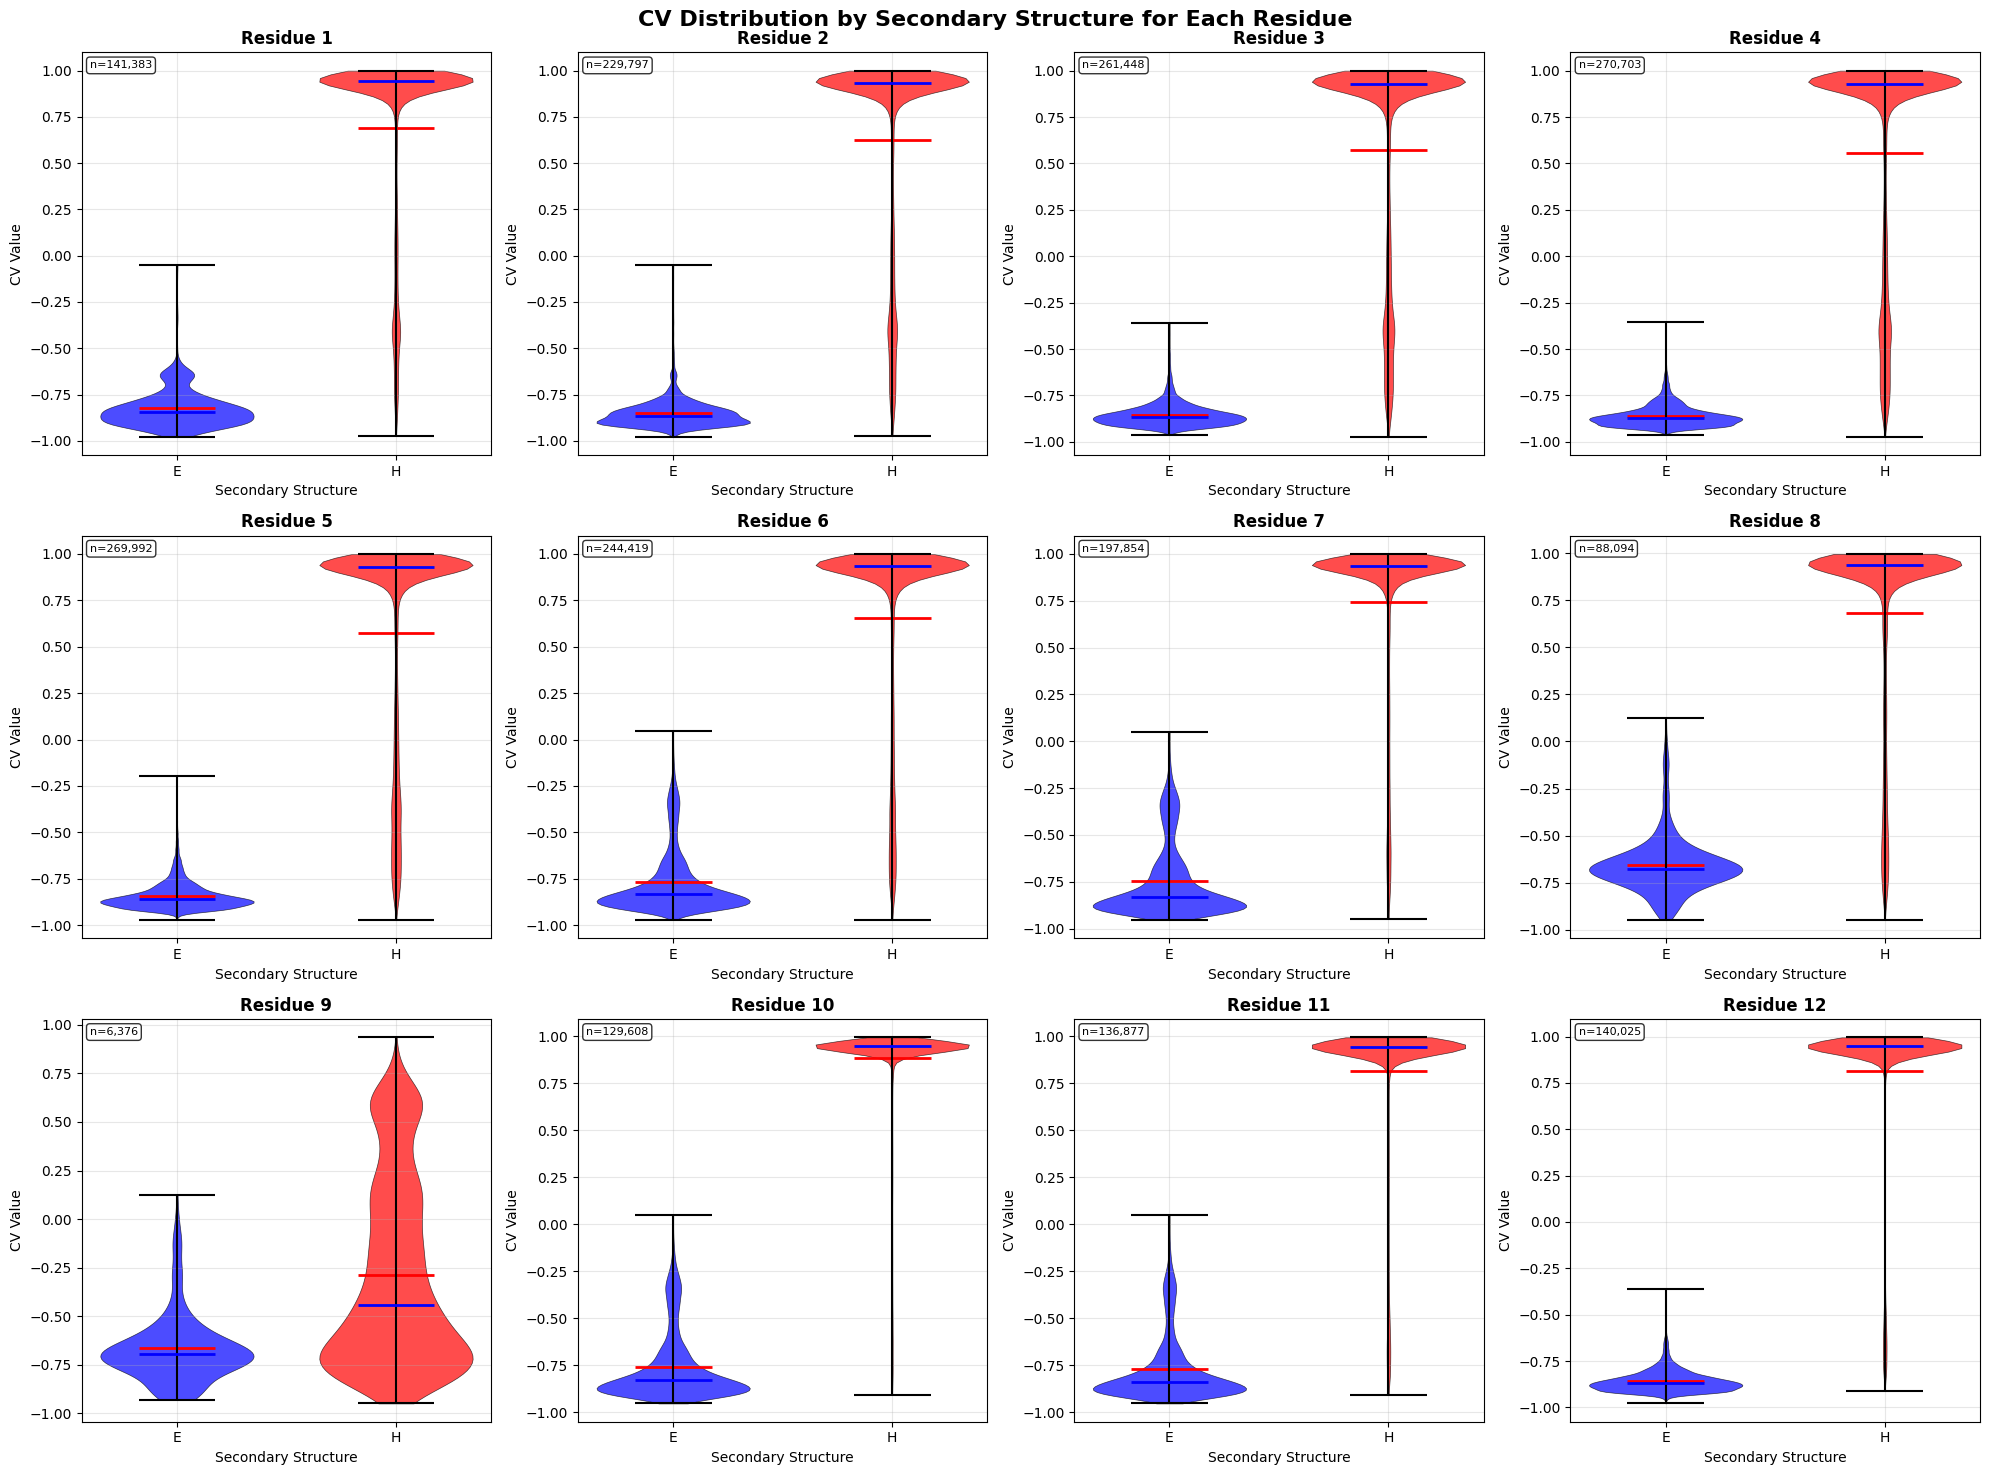

\nDetailed Residue Statistics:
\nResidue 1:
------------------------------
  SS-E:
    Frames: 855
    Mean CV: -0.8255
    Std CV: 0.1046
    Range: [-0.9782, -0.0499]
  SS-H:
    Frames: 140,528
    Mean CV: 0.6919
    Std CV: 0.5195
    Range: [-0.9726, 1.0000]
\nResidue 2:
------------------------------
  SS-E:
    Frames: 4,636
    Mean CV: -0.8520
    Std CV: 0.0726
    Range: [-0.9782, -0.0499]
  SS-H:
    Frames: 225,161
    Mean CV: 0.6260
    Std CV: 0.5667
    Range: [-0.9726, 1.0000]
\nResidue 3:
------------------------------
  SS-E:
    Frames: 6,870
    Mean CV: -0.8540
    Std CV: 0.0617
    Range: [-0.9633, -0.3584]
  SS-H:
    Frames: 254,578
    Mean CV: 0.5749
    Std CV: 0.5999
    Range: [-0.9726, 1.0000]
\nResidue 4:
------------------------------
  SS-E:
    Frames: 10,385
    Mean CV: -0.8589
    Std CV: 0.0599
    Range: [-0.9633, -0.3565]
  SS-H:
    Frames: 260,318
    Mean CV: 0.5538
    Std CV: 0.6133
    Range: [-0.9726, 1.0000]
\nResidue 5:
-------------

In [34]:
## Per-Residue Secondary Structure Violin Plots

# Create violin plots for each residue showing CV distribution across secondary structures
# X-axis: Secondary Structure Types
# Y-axis: CV Values
# One plot per residue

import matplotlib.pyplot as plt
from collections import defaultdict

print("Creating per-residue secondary structure violin plots...")
print(f"Available secondary structure types: {ss_types}")

# Collect data for each residue
residue_data = {}
min_frames_threshold = 20  # Minimum frames needed for each SS type to include in violin

for residue_idx in range(dssp.shape[1]):
    # Collect CV values for each secondary structure at this residue
    ss_cv_data = defaultdict(list)
    
    for cv_dim in range(MLCV_DIM):
        cv_values = cv[:, cv_dim]
        
        for frame_idx in range(len(dssp)):
            ss_type = dssp[frame_idx, residue_idx]
            ss_cv_data[ss_type].append(cv_values[frame_idx])
    
    # Filter secondary structures that have enough data points
    filtered_ss_data = {}
    for ss_type in ss_types:
        if ss_type in ss_cv_data and len(ss_cv_data[ss_type]) >= min_frames_threshold:
            filtered_ss_data[ss_type] = ss_cv_data[ss_type]
    
    # Only store residue data if it has multiple secondary structures
    if len(filtered_ss_data) >= 2:
        residue_data[residue_idx] = filtered_ss_data

print(f"Found {len(residue_data)} residues with sufficient secondary structure diversity")

# Create plots for selected residues
# Show first 12 residues with data, or all if less than 12
max_plots = 12
selected_residues = sorted(list(residue_data.keys()))[:max_plots]

if len(selected_residues) > 0:
    # Calculate grid size
    n_cols = 4
    n_rows = (len(selected_residues) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    axes = axes.flatten()
    
    for plot_idx, residue_idx in enumerate(selected_residues):
        ax = axes[plot_idx]
        ss_data = residue_data[residue_idx]
        
        # Prepare data for violin plot
        ss_types_present = sorted(ss_data.keys())
        cv_data_list = [ss_data[ss_type] for ss_type in ss_types_present]
        
        # Create violin plot
        violin_parts = ax.violinplot(
            cv_data_list,
            positions=range(len(ss_types_present)),
            showmeans=True,
            showmedians=True,
            widths=0.7
        )
        
        # Style the violins with secondary structure colors
        for i, (pc, ss_type) in enumerate(zip(violin_parts['bodies'], ss_types_present)):
            pc.set_facecolor(ss_colors.get(ss_type, 'gray'))
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.5)
        
        # Style other elements
        violin_parts['cbars'].set_edgecolor('black')
        violin_parts['cmaxes'].set_edgecolor('black')
        violin_parts['cmins'].set_edgecolor('black')
        violin_parts['cmeans'].set_edgecolor('red')
        violin_parts['cmeans'].set_linewidth(2)
        violin_parts['cmedians'].set_edgecolor('blue')
        violin_parts['cmedians'].set_linewidth(2)
        
        # Customize plot
        ax.set_xlabel('Secondary Structure', fontsize=10)
        ax.set_ylabel('CV Value', fontsize=10)
        ax.set_title(f'Residue {residue_idx}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Set x-axis labels
        ss_labels = ['Coil' if ss == ' ' else ss for ss in ss_types_present]
        ax.set_xticks(range(len(ss_types_present)))
        ax.set_xticklabels(ss_labels)
        
        # Add statistics text
        total_frames = sum(len(data) for data in cv_data_list)
        stats_text = f'n={total_frames:,}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               verticalalignment='top', fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(selected_residues), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('CV Distribution by Secondary Structure for Each Residue', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics for each residue
    print("\\nDetailed Residue Statistics:")
    print("=" * 70)
    
    for residue_idx in selected_residues[:6]:  # Show stats for first 6 residues
        print(f"\\nResidue {residue_idx}:")
        print("-" * 30)
        ss_data = residue_data[residue_idx]
        
        for ss_type in sorted(ss_data.keys()):
            cv_vals = ss_data[ss_type]
            ss_name = 'Coil' if ss_type == ' ' else f'SS-{ss_type}'
            
            print(f"  {ss_name}:")
            print(f"    Frames: {len(cv_vals):,}")
            print(f"    Mean CV: {np.mean(cv_vals):.4f}")
            print(f"    Std CV: {np.std(cv_vals):.4f}")
            print(f"    Range: [{np.min(cv_vals):.4f}, {np.max(cv_vals):.4f}]")
    
else:
    print("No residues found with sufficient secondary structure diversity for analysis.")
    print("This could mean:")
    print("- Most residues adopt only one secondary structure")
    print("- The minimum frames threshold is too high")
    print("- The protein has very stable secondary structure")

print(f"\\nAnalysis complete! Shown plots for {len(selected_residues)} residues.")


In [ ]:
## Summary and Key Insights

# Create a summary analysis of the most interesting findings
print("🎯 KEY INSIGHTS FROM SECONDARY STRUCTURE ANALYSIS:")
print("=" * 60)

if len(residue_data) > 0:
    # Find residues with highest CV variance across secondary structures
    variance_analysis = []
    
    for residue_idx, ss_data in residue_data.items():
        if len(ss_data) >= 2:  # Need at least 2 SS types
            # Calculate variance in CV means across secondary structures
            ss_means = [np.mean(cv_vals) for cv_vals in ss_data.values()]
            cv_variance_across_ss = np.var(ss_means)
            
            variance_analysis.append({
                'residue': residue_idx,
                'variance': cv_variance_across_ss,
                'ss_count': len(ss_data),
                'ss_types': list(ss_data.keys()),
                'mean_range': max(ss_means) - min(ss_means)
            })
    
    # Sort by variance (highest first)
    variance_analysis.sort(key=lambda x: x['variance'], reverse=True)
    
    print("\\n📊 RESIDUES WITH HIGHEST CV SENSITIVITY TO SECONDARY STRUCTURE:")
    print("Residue | SS Types | CV Range | Variance")
    print("-" * 45)
    
    for i, res_info in enumerate(variance_analysis[:8]):
        ss_names = ['Coil' if ss == ' ' else ss for ss in res_info['ss_types']]
        print(f"{res_info['residue']:^7} | {len(ss_names):^8} | {res_info['mean_range']:^8.3f} | {res_info['variance']:^8.4f}")
    
    print(f"\\n📈 SUMMARY STATISTICS:")
    print(f"  • Total residues analyzed: {len(residue_data)}")
    print(f"  • Residues with 2+ SS types: {len(variance_analysis)}")
    print(f"  • Most diverse residue: {variance_analysis[0]['residue']} ({variance_analysis[0]['ss_count']} SS types)")
    print(f"  • Highest CV range: {max(r['mean_range'] for r in variance_analysis):.3f}")
    
    print(f"\\n🔍 INTERPRETATION:")
    print("  • Higher variance = CV is more sensitive to secondary structure at that residue")
    print("  • High CV range = Large difference in CV values between SS types")
    print("  • These residues are key for understanding structure-CV relationships")
    
else:
    print("No residues found with sufficient secondary structure diversity.")
    print("Consider:")
    print("  • Lowering the minimum frames threshold")
    print("  • Checking if the protein has dynamic secondary structure")
    print("  • Verifying the DSSP data quality")

print("\\n✅ Analysis complete! Use these insights to focus on structurally important residues.")


### asdf

In [21]:
dssp_simplified_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp-simplified.npy"
dssp_simplified = np.load(dssp_simplified_path)

print(np.unique(dssp_simplified))
print(dssp_simplified.shape)
print(dssp_simplified[0])

['C' 'E' 'H']
(1044000, 20)
['C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'C' 'C' 'H' 'H' 'H' 'H' 'C' 'C' 'C' 'C'
 'C' 'C']


Secondary structure types: ['C' 'E' 'H']

Creating violin plot for Secondary Structure C...


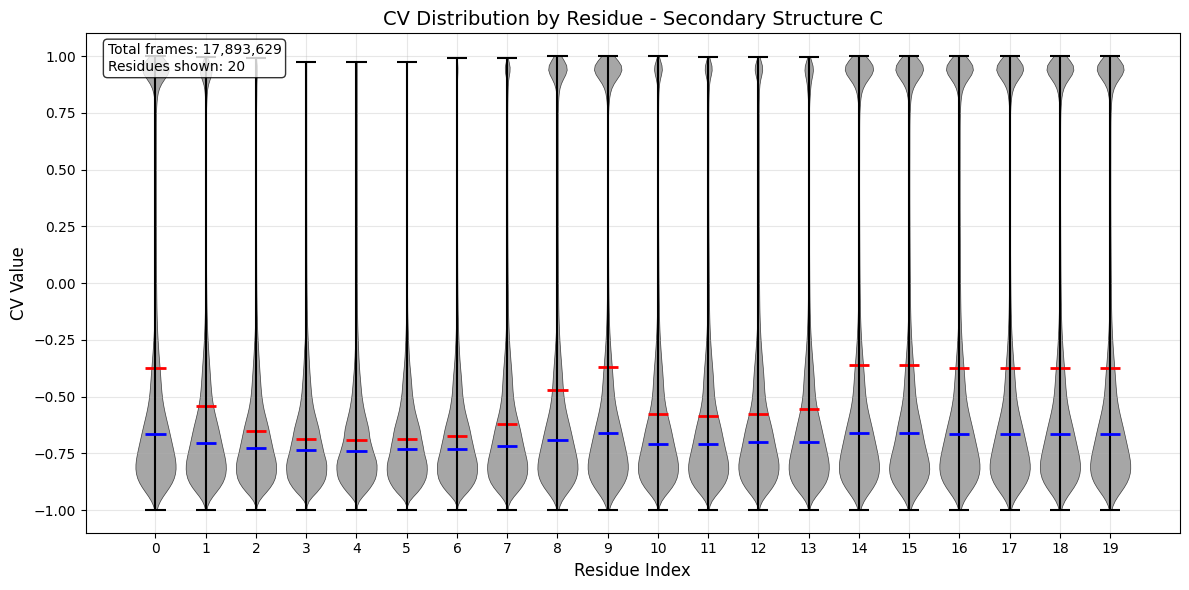

  - Residues with Secondary Structure C: 20
  - Total data points: 17,893,629
  - Average points per residue: 894681.4

Creating violin plot for Secondary Structure E...


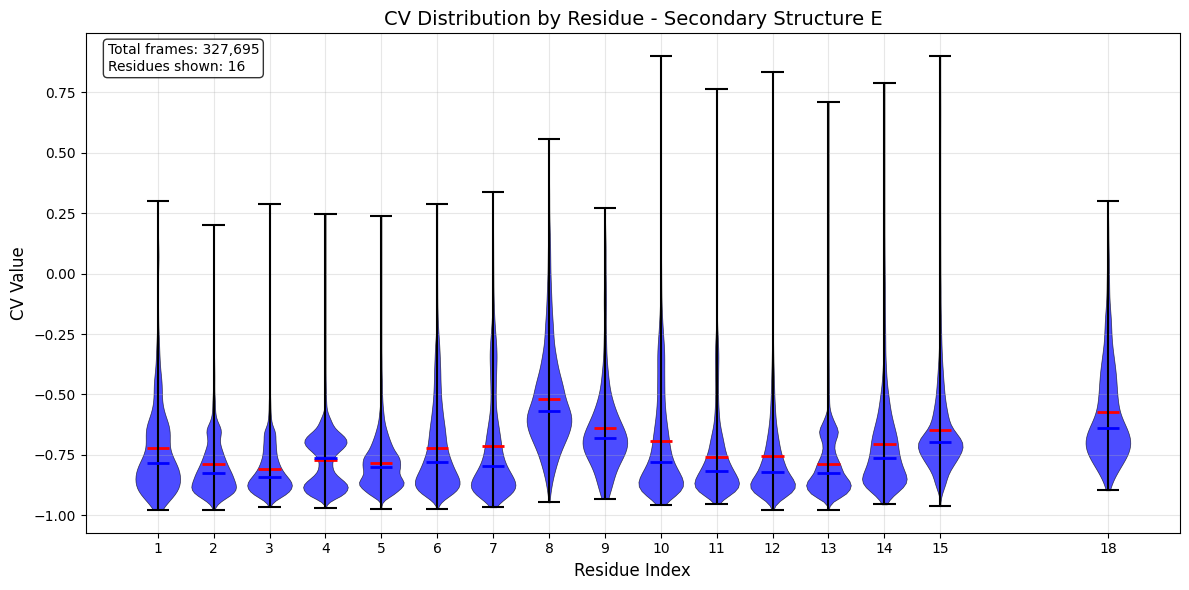

  - Residues with Secondary Structure E: 16
  - Total data points: 327,695
  - Average points per residue: 20480.9

Creating violin plot for Secondary Structure H...


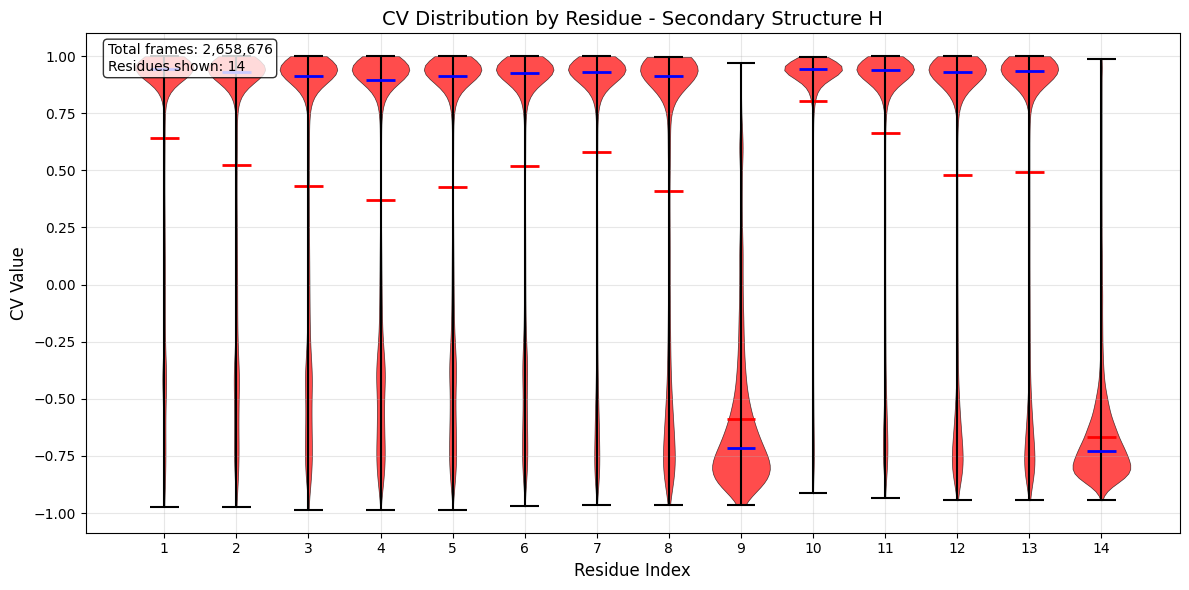

  - Residues with Secondary Structure H: 14
  - Total data points: 2,658,676
  - Average points per residue: 189905.4

Violin plots completed!


In [19]:
## Secondary Structure Violin Plots by Residue

import seaborn as sns
from collections import defaultdict

# Secondary structure types in the data
ss_types = np.unique(dssp_simplified)
print(f"Secondary structure types: {ss_types}")

# Colors for different secondary structures
ss_colors = {
    ' ': 'lightgray',    # Coil
    'B': 'orange',       # Beta bridge
    'E': 'blue',         # Extended/Beta sheet
    'G': 'green',        # 3-helix
    'H': 'red',          # Alpha helix
    'I': 'purple',       # 5-helix/Pi helix
    'S': 'cyan',         # Bend
    'T': 'yellow'        # Turn
}

# Create a separate plot for each secondary structure type
for ss_type in ss_types:
    if ss_type == ' ':
        ss_name = 'Coil'
    else:
        ss_name = f'Secondary Structure {ss_type}'
    
    print(f"\nCreating violin plot for {ss_name}...")
    
    # Collect CV values for each residue that has this secondary structure
    residue_cv_data = defaultdict(list)
    
    # For each CV dimension
    for cv_dim in range(MLCV_DIM):
        cv_values = cv[:, cv_dim]
        
        # Go through each frame
        for frame_idx in range(len(dssp_simplified)):
            # Check each residue in this frame
            for residue_idx in range(dssp_simplified.shape[1]):
                if dssp_simplified[frame_idx, residue_idx] == ss_type:
                    residue_cv_data[residue_idx].append(cv_values[frame_idx])
    
    # Only plot if we have data for this secondary structure
    if residue_cv_data:
        # Prepare data for violin plot
        residues = sorted(residue_cv_data.keys())
        cv_data_by_residue = [residue_cv_data[res] for res in residues]
        
        # Filter out residues with too few data points
        min_points = 100  # Minimum number of points for a meaningful violin
        filtered_residues = []
        filtered_cv_data = []
        
        for i, res in enumerate(residues):
            if len(cv_data_by_residue[i]) >= min_points:
                filtered_residues.append(res)
                filtered_cv_data.append(cv_data_by_residue[i])
        
        if filtered_cv_data:
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Create violin plot
            violin_parts = ax.violinplot(
                filtered_cv_data,
                positions=filtered_residues,
                showmeans=True,
                showmedians=True,
                widths=0.8
            )
            
            # Style the violins
            for pc in violin_parts['bodies']:
                pc.set_facecolor(ss_colors.get(ss_type, 'gray'))
                pc.set_alpha(0.7)
                pc.set_edgecolor('black')
                pc.set_linewidth(0.5)
            
            # Style other elements
            violin_parts['cbars'].set_edgecolor('black')
            violin_parts['cmaxes'].set_edgecolor('black')
            violin_parts['cmins'].set_edgecolor('black')
            violin_parts['cmeans'].set_edgecolor('red')
            violin_parts['cmeans'].set_linewidth(2)
            violin_parts['cmedians'].set_edgecolor('blue')
            violin_parts['cmedians'].set_linewidth(2)
            
            # Customize plot
            ax.set_xlabel('Residue Index', fontsize=12)
            ax.set_ylabel('CV Value', fontsize=12)
            ax.set_title(f'CV Distribution by Residue - {ss_name}', fontsize=14)
            ax.grid(True, alpha=0.3)
            
            # Add statistics text
            total_frames = sum(len(data) for data in filtered_cv_data)
            stats_text = f'Total frames: {total_frames:,}\nResidues shown: {len(filtered_residues)}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top', fontsize=10)
            
            # Set x-axis ticks
            if len(filtered_residues) <= 20:
                ax.set_xticks(filtered_residues)
            else:
                # Show every 5th residue if too many
                step = max(1, len(filtered_residues) // 10)
                tick_positions = filtered_residues[::step]
                ax.set_xticks(tick_positions)
            
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            print(f"  - Residues with {ss_name}: {len(filtered_residues)}")
            print(f"  - Total data points: {total_frames:,}")
            print(f"  - Average points per residue: {total_frames/len(filtered_residues):.1f}")
        else:
            print(f"  - Not enough data points for {ss_name} (minimum {min_points} required)")
    else:
        print(f"  - No data found for {ss_name}")

print("\nViolin plots completed!")


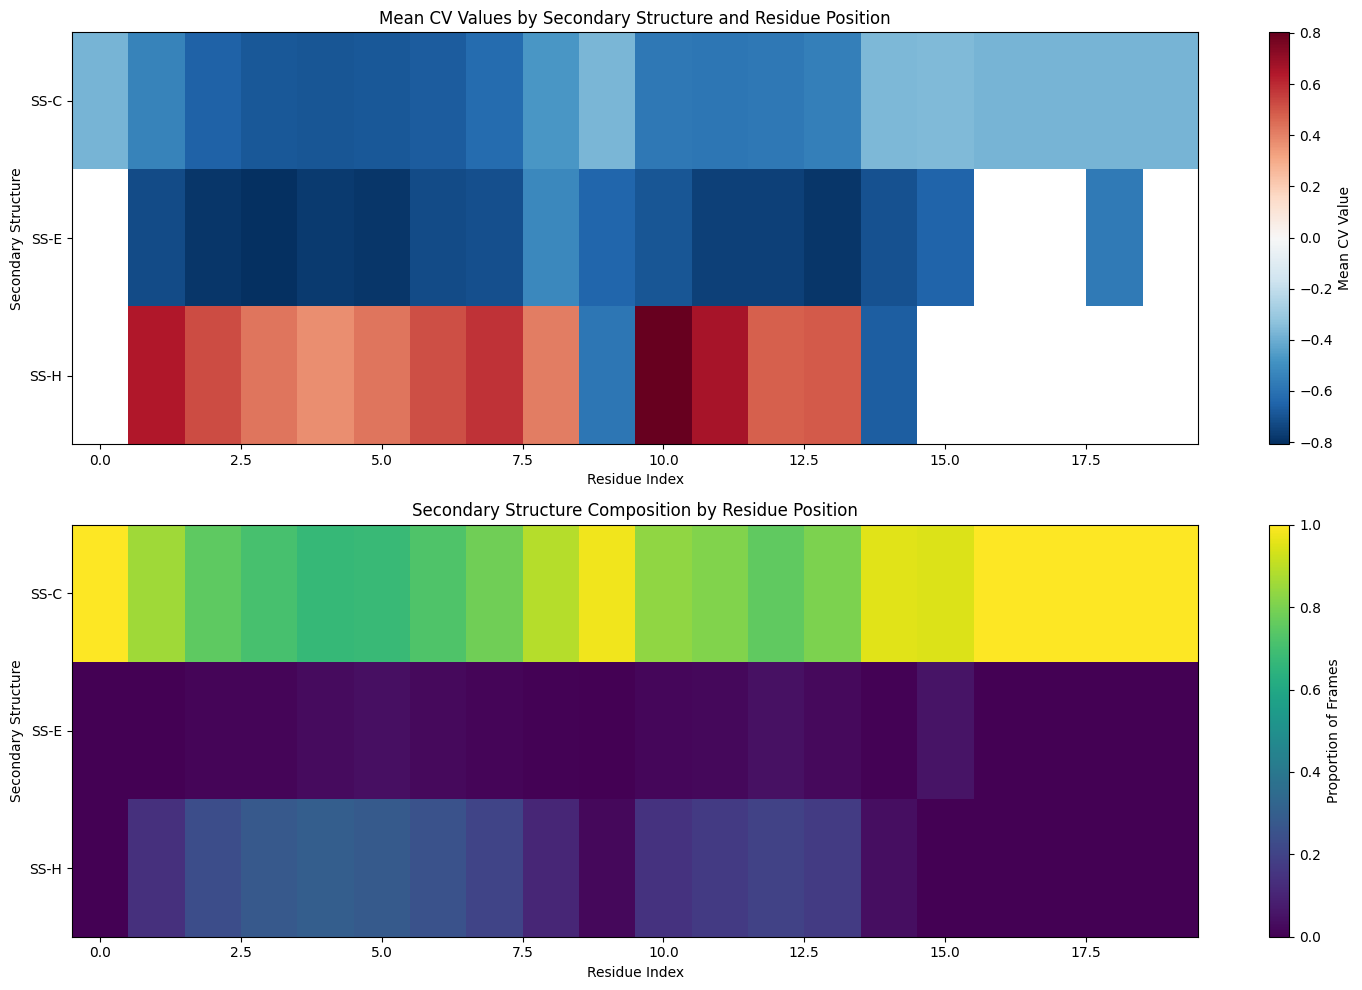


Statistical Analysis of CV by Secondary Structure:
One-way ANOVA:
  F-statistic: 3718718.5000
  P-value: 0.00e+00
  Significant difference: Yes

Pairwise CV Distribution Comparisons (t-tests):
--------------------------------------------------
SS-C vs SS-E:
  t-statistic: 251.6812
  p-value: 0.00e+00
  Significant: Yes

SS-C vs SS-H:
  t-statistic: -2682.6540
  p-value: 0.00e+00
  Significant: Yes

SS-E vs SS-H:
  t-statistic: -1017.5507
  p-value: 0.00e+00
  Significant: Yes

Analysis completed! 🎉


In [24]:
## Comparative Analysis and Heatmap

# Create a heatmap showing mean CV values for each secondary structure at each residue
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Prepare data for heatmap
residue_range = range(dssp_simplified.shape[1])  # All residue positions
heatmap_data = np.full((len(ss_types), len(residue_range)), np.nan)
ss_type_labels = []

for ss_idx, ss_type in enumerate(ss_types):
    ss_name = 'Coil' if ss_type == ' ' else f'SS-{ss_type}'
    ss_type_labels.append(ss_name)
    
    for res_idx in residue_range:
        # Collect CV values for this residue when it has this secondary structure
        cv_values_for_residue = []
        
        for frame_idx in range(len(dssp_simplified)):
            if dssp_simplified[frame_idx, res_idx] == ss_type:
                cv_values_for_residue.append(cv[frame_idx, 0])  # Using first CV dimension
        
        if len(cv_values_for_residue) > 10:  # Minimum threshold for meaningful average
            heatmap_data[ss_idx, res_idx] = np.mean(cv_values_for_residue)

# Plot heatmap
im1 = ax1.imshow(heatmap_data, aspect='auto', cmap='RdBu_r', interpolation='nearest')
ax1.set_xlabel('Residue Index')
ax1.set_ylabel('Secondary Structure')
ax1.set_title('Mean CV Values by Secondary Structure and Residue Position')
ax1.set_yticks(range(len(ss_type_labels)))
ax1.set_yticklabels(ss_type_labels)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Mean CV Value')

# Create a secondary structure composition plot
ss_composition = np.zeros((len(ss_types), dssp_simplified.shape[1]))

for res_idx in range(dssp_simplified.shape[1]):
    for frame_idx in range(len(dssp_simplified)):
        ss_type = dssp_simplified[frame_idx, res_idx]
        ss_idx = list(ss_types).index(ss_type)
        ss_composition[ss_idx, res_idx] += 1

# Normalize to get proportions
ss_composition = ss_composition / len(dssp_simplified)

# Plot composition
im2 = ax2.imshow(ss_composition, aspect='auto', cmap='viridis', interpolation='nearest')
ax2.set_xlabel('Residue Index')
ax2.set_ylabel('Secondary Structure')
ax2.set_title('Secondary Structure Composition by Residue Position')
ax2.set_yticks(range(len(ss_type_labels)))
ax2.set_yticklabels(ss_type_labels)

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Proportion of Frames')

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nStatistical Analysis of CV by Secondary Structure:")
print("=" * 65)

from scipy import stats

# Collect CV values for each secondary structure type
ss_cv_distributions = {}
for ss_type in ss_types:
	if ss_type == ' ':
		continue
	else:
		cv_values = []
		for frame_idx in range(len(dssp_simplified)):
			for res_idx in range(dssp_simplified.shape[1]):
				if dssp_simplified[frame_idx, res_idx] == ss_type:
					cv_values.append(cv[frame_idx, 0])
		if cv_values:
			ss_cv_distributions[ss_type] = np.array(cv_values)

# Perform ANOVA test
if len(ss_cv_distributions) > 1:
    # Prepare data for ANOVA
    anova_data = [values for values in ss_cv_distributions.values() if len(values) > 100]
    
    if len(anova_data) > 1:
        f_stat, p_value = stats.f_oneway(*anova_data)
        print(f"One-way ANOVA:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  P-value: {p_value:.2e}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        print()

# Pairwise comparisons
print("Pairwise CV Distribution Comparisons (t-tests):")
print("-" * 50)

ss_types_with_data = [ss for ss in ss_types if ss in ss_cv_distributions and len(ss_cv_distributions[ss]) > 100]

for i, ss1 in enumerate(ss_types_with_data):
    for ss2 in ss_types_with_data[i+1:]:
        t_stat, p_val = stats.ttest_ind(ss_cv_distributions[ss1], ss_cv_distributions[ss2])
        ss1_name = 'Coil' if ss1 == ' ' else f'SS-{ss1}'
        ss2_name = 'Coil' if ss2 == ' ' else f'SS-{ss2}'
        
        print(f"{ss1_name} vs {ss2_name}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_val:.2e}")
        print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")
        print()

print("Analysis completed! 🎉")


# Conclusion